In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

import tensorflow as tf
from setup_mnist import MNIST
from setup_cifar import CIFAR
import os

def train(data, file_name, params, num_epochs=30, batch_size=50, train_temp=1, init=None):
    """
    Standard neural network training procedure.
    """
    model = Sequential()

    print(data.train_data.shape)
    
    model.add(Conv2D(params[0], (5, 5), padding='same',
                            input_shape=data.train_data.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    model.add(Conv2D(params[1], (5, 5), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    model.add(Conv2D(params[2], (4, 4), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    model.add(Flatten())
    model.add(Dense(10))
    
    model.summary()

    
    
#     model.add(Conv2D(params[2], (3, 3)))
#     model.add(Activation('relu'))
#     model.add(Conv2D(params[3], (3, 3)))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Flatten())
#     model.add(Dense(params[4]))
#     model.add(Activation('relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(params[5]))
#     model.add(Activation('relu'))
#     model.add(Dense(10))
    
    if init != None:
        model.load_weights(init)

    def fn(correct, predicted):
        return tf.nn.softmax_cross_entropy_with_logits(labels=correct,
                                                       logits=predicted/train_temp)

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(loss=fn,
                  optimizer=sgd,
                  metrics=['accuracy'])
    
    model.fit(data.train_data, data.train_labels,
              batch_size=batch_size,
              validation_data=(data.validation_data, data.validation_labels),
              epochs=num_epochs,
              shuffle=True)
    

    if file_name != None:
        model.save(file_name)

    return model

def train_distillation(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1):
    """
    Train a network using defensive distillation.
    Distillation as a Defense to Adversarial Perturbations against Deep Neural Networks
    Nicolas Papernot, Patrick McDaniel, Xi Wu, Somesh Jha, Ananthram Swami
    IEEE S&P, 2016.
    """
    if not os.path.exists(file_name+"_init"):
        # Train for one epoch to get a good starting point.
        train(data, file_name+"_init", params, 1, batch_size)
    
    # now train the teacher at the given temperature
    teacher = train(data, file_name+"_teacher", params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # evaluate the labels at temperature t
    predicted = teacher.predict(data.train_data)
    with tf.Session() as sess:
        y = sess.run(tf.nn.softmax(predicted/train_temp))
        print(y)
        data.train_labels = y

    # train the student model at temperature t
    student = train(data, file_name, params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # and finally we predict at temperature 1
    predicted = student.predict(data.train_data)

    print(predicted)

/home/tianwei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# # dont need to train again
# if not os.path.isdir('models'):
#     os.makedirs('models')

# hidden_param = [10, 25, 100]
# train(MNIST(), "models/mnist", hidden_param, num_epochs=30)

# train_distillation(MNIST(), "models/mnist-distilled-100", hidden_param,
#                    num_epochs=30, train_temp=100)

In [3]:
import tensorflow as tf
import numpy as np
import time

from setup_cifar import CIFAR, CIFARModel
from setup_mnist import MNIST, MNISTModel
from setup_inception import ImageNet, InceptionModel

from l2_attack import CarliniL2
from l0_attack import CarliniL0
from li_attack import CarliniLi


# def show(img):
#     """
#     Show MNSIT digits in the console.
#     """
#     remap = "  .*#"+"#"*100
#     img = (img.flatten()+.5)*3
#     if len(img) != 784: return
#     print("START")
#     for i in range(28):
#         print("".join([remap[int(round(x))] for x in img[i*28:i*28+28]]))


def generate_data(data, samples, targeted=True, start=0, inception=False):
    """
    Generate the input data to the attack algorithm.
    data: the images to attack
    samples: number of samples to use
    targeted: if true, construct targeted attacks, otherwise untargeted attacks
    start: offset into data to use
    inception: if targeted and inception, randomly sample 100 targets intead of 1000
    """
    inputs = []
    targets = []
    for i in range(samples):
        if targeted:
            if inception:
                seq = random.sample(range(1,1001), 10)
            else:
                seq = range(data.test_labels.shape[1])

            for j in seq:
                if (j == np.argmax(data.test_labels[start+i])) and (inception == False):
                    continue
                inputs.append(data.test_data[start+i])
                targets.append(np.eye(data.test_labels.shape[1])[j])
        else:
            inputs.append(data.test_data[start+i])
            targets.append(data.test_labels[start+i])

    inputs = np.array(inputs)
    targets = np.array(targets)

    return inputs, targets

In [4]:
# sess = tf.Session()
# tf.global_variables_initializer().run()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
# sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

data, model =  MNIST(), MNISTModel("models/mnist", sess)
attack = CarliniLi(sess, model,  max_iterations=1000)
# attack = CarliniL2(sess, model, batch_size=9, max_iterations=1000, confidence=0)

inputs, targets = generate_data(data, samples=1, targeted=True,
                                start=0, inception=False)

In [5]:
print(inputs.shape )
print(targets )

(9, 28, 28, 1)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [6]:
timestart = time.time()
adv = attack.attack(inputs, targets)
timeend = time.time()

print("Took",timeend-timestart,"seconds to run",len(inputs),"samples.")

try const 1e-05
0 (0.0004021787, 40.217873, 0.0)
100 (0.00028254057, 28.254059, 0.0)
200 (0.00016580289, 16.58029, 0.0)
300 (4.877715e-05, 4.877715, 0.0)
Tau 0.7555637
try const 1e-05
0 (0.23478383, 0.0, 0.23478383)
Tau 0.6799226
try const 1e-05
0 (0.6342552, 0.0, 0.6342552)
Tau 0.61018336
try const 1e-05
0 (1.0905302, 0.0, 1.0905302)
Tau 0.545622
try const 1e-05
0 (1.72401, 0.0, 1.72401)
100 (2.6590747e-05, 2.6590748, 0.0)
200 (2.226068e-05, 2.226068, 0.0)
300 (1.776751e-05, 1.776751, 0.0)
400 (1.5845784e-05, 1.5845785, 0.0)
500 (1.5138749e-05, 1.513875, 0.0)
600 (1.47761675e-05, 1.4776168, 0.0)
700 (1.2942119e-05, 1.2942119, 0.0)
800 (1.663688e-05, 1.1570487, 5.066395e-06)
900 (1.032876e-05, 1.032876, 0.0)
try const 2e-05
0 (1.9382762e-05, 0.96913815, 0.0)
100 (1.8940944e-05, 0.94704723, 0.0)
200 (1.8602972e-05, 0.9301486, 0.0)
300 (1.8364277e-05, 0.91821384, 0.0)
400 (1.8147983e-05, 0.9073992, 0.0)
500 (1.7661467e-05, 0.88307333, 0.0)
600 (1.731038e-05, 0.86551905, 0.0)
700 (1.71414

100 (0.14522384, 3.5387492, 0.00027666986)
200 (0.12412477, 3.0067687, 0.0009675324)
300 (0.12342889, 3.002564, 0.0004438758)
400 (0.123829596, 3.0023408, 0.0008537173)
500 (0.123920165, 3.011702, 0.0005608499)
600 (0.1243047, 3.0116663, 0.0009468496)
700 (0.124629416, 3.009778, 0.0013489127)
800 (0.12327973, 2.9818616, 0.0011426806)
900 (0.12324495, 2.9768543, 0.0013130009)
try const 0.08192
0 (0.24668427, 2.9977036, 0.0011124015)
100 (0.23289172, 2.811533, 0.002570942)
200 (0.23178297, 2.7965736, 0.0026876628)
300 (0.23082528, 2.8027244, 0.0012260973)
400 (0.23010729, 2.7719169, 0.0030318648)
500 (0.23076782, 2.7859912, 0.002539426)
600 (0.23029146, 2.7811828, 0.002456963)
700 (0.22785264, 2.7547092, 0.0021868646)
800 (0.22921398, 2.7730742, 0.0020437539)
900 (0.2275508, 2.7527966, 0.0020417124)
try const 0.16384
0 (0.4495756, 2.7255125, 0.0030276328)
100 (0.43944559, 2.6463456, 0.0058683157)
200 (0.4357082, 2.6240616, 0.0057819486)
300 (0.43222225, 2.6072922, 0.0050434917)
400 (0.43

100 (0.043225717, 4.2382336, 0.040513247)
200 (0.013997643, 3.7457318, 0.011600375)
300 (0.013048827, 3.266007, 0.010958582)
400 (0.0016774567, 2.621026, 0.0)
500 (0.0014244665, 2.225729, 0.0)
600 (0.0010760434, 1.6813178, 0.0)
700 (0.00072898617, 1.139041, 0.0)
800 (0.00052824063, 0.82537603, 0.0)
900 (0.00039287505, 0.6138673, 0.0)
try const 0.00128
0 (0.00063297176, 0.49450922, 0.0)
100 (0.000618999, 0.483593, 0.0)
200 (5.6212157e-05, 0.04391575, 0.0)
Tau 0.23314428
try const 0.00128
0 (2.130739, 0.0, 2.130739)
100 (0.022153258, 3.558363, 0.017598554)
200 (0.0036114983, 2.8214831, 0.0)
300 (0.002834287, 2.2142868, 0.0)
400 (0.002361192, 1.8446813, 0.0)
500 (0.0020490703, 1.6008363, 0.0)
600 (0.0019073425, 1.4901114, 0.0)
700 (0.0016583166, 1.2955599, 0.0)
800 (0.0011623224, 0.90806437, 0.0)
900 (0.0009742169, 0.76110697, 0.0)
try const 0.00256
0 (0.0013420776, 0.5242491, 0.0)
100 (0.0013677654, 0.5249934, 2.3782253e-05)
200 (0.000887389, 0.32734632, 4.938245e-05)
Tau 0.2098298549652

100 (0.033599507, 1.6797938, 0.03333074)
200 (0.029154224, 1.6420059, 0.028891504)
300 (0.00025811614, 1.6132259, 0.0)
400 (0.0002520012, 1.5750074, 0.0)
500 (0.00024486153, 1.5303845, 0.0)
600 (0.00023383666, 1.4614792, 0.0)
700 (2.8726195e-06, 0.017953873, 0.0)
Tau 0.38065088
try const 0.00016
0 (1.5680288, 0.0, 1.5680288)
100 (0.006834185, 2.6740513, 0.006406337)
200 (0.00664813, 2.4524002, 0.006255746)
300 (0.0040516043, 1.5397139, 0.00380525)
400 (3.846954e-05, 0.24043465, 0.0)
Tau 0.34026337
try const 0.00016
0 (1.2568177, 0.0, 1.2568177)
100 (0.056373894, 2.6645174, 0.055947572)
200 (0.034045536, 2.4016304, 0.033661276)
300 (0.021384947, 1.762764, 0.021102905)
400 (0.00015430541, 0.9644089, 0.0)
500 (4.9205017e-05, 0.30753136, 0.0)
600 (3.473694e-05, 0.21710587, 0.0)
Tau 0.30487838
try const 0.00016
0 (1.1517246, 0.0, 1.1517246)
100 (0.027896892, 2.672409, 0.027469307)
200 (0.026616693, 2.199973, 0.026264697)
300 (0.0073304498, 1.7294817, 0.007053733)
400 (0.00019601226, 1.22507

600 (0.20645945, 0.0, 0.20645945)
700 (0.21981429, 0.0, 0.21981429)
800 (0.40702504, 0.0, 0.40702504)
900 (0.25738263, 0.0, 0.25738263)
try const 10.48576
0 (0.24168183, 0.0, 0.24168183)
100 (0.34891036, 0.0, 0.34891036)
200 (0.45870864, 0.0, 0.45870864)
300 (0.29045784, 0.0, 0.29045784)
400 (0.45181853, 0.013716698, 0.30798852)
500 (0.3009399, 0.0, 0.3009399)
600 (0.3021074, 0.0, 0.3021074)
700 (0.40195692, 0.0, 0.40195692)
800 (0.2941852, 0.0, 0.2941852)
900 (0.2896284, 0.0, 0.2896284)
try const 1e-05
0 (0.00026887018, 26.887018, 0.0)
100 (9.4889954e-05, 9.488996, 0.0)
Tau 0.41635227
try const 1e-05
0 (0.12551177, 0.0, 0.12551177)
Tau 0.37333414
try const 1e-05
0 (0.5918577, 0.0, 0.5918577)
Tau 0.33026582
try const 1e-05
0 (0.965625, 0.0, 0.965625)
Tau 0.2913015
try const 1e-05
0 (0.7474743, 0.0, 0.7474743)
Tau 0.25997043
try const 1e-05
0 (0.524548, 0.0, 0.524548)
100 (1.1835479e-05, 1.183548, 0.0)
200 (9.415493e-06, 0.9415493, 0.0)
300 (8.803272e-06, 0.8803272, 0.0)
400 (8.309612e-

try const 0.08192
0 (0.18691027, 2.2733479, 0.00067760795)
100 (0.17989437, 2.1691952, 0.0021939129)
200 (0.18037441, 2.1679745, 0.0027739555)
300 (0.1784924, 2.145378, 0.0027430207)
400 (0.17717035, 2.122099, 0.0033280104)
500 (0.17825842, 2.1415577, 0.0028220192)
600 (0.17701907, 2.129469, 0.0025729835)
700 (0.17722638, 2.1384964, 0.0020407587)
800 (0.17686643, 2.1398048, 0.0015736222)
900 (0.1769175, 2.1362495, 0.0019159243)
try const 0.16384
0 (0.34902552, 2.1183872, 0.0019489601)
100 (0.3414774, 2.0429993, 0.0067524016)
200 (0.34046137, 2.0456848, 0.005296387)
300 (0.34010702, 2.0502968, 0.004186429)
400 (0.33865604, 2.0391579, 0.0045604184)
500 (0.338732, 2.0295868, 0.006204501)
600 (0.3371091, 2.0324879, 0.0041062683)
700 (0.33767337, 2.035471, 0.004181817)
800 (0.33698317, 2.0178185, 0.0063838065)
900 (0.33631292, 2.0208912, 0.0052101016)
try const 0.32768
0 (0.6680678, 2.0212116, 0.005757205)
100 (0.47401738, 0.0034446716, 0.47288862)
200 (0.45965987, 0.0, 0.45965987)
300 (0.4

500 (0.000688407, 2.1512718, 0.0)
600 (0.00059144286, 1.848259, 0.0)
700 (0.00051075866, 1.5961208, 0.0)
800 (0.00039881773, 1.2463055, 0.0)
900 (0.0003094107, 0.96690845, 0.0)
try const 0.00064
0 (0.00027785765, 0.4341526, 0.0)
100 (0.00013454224, 0.21022224, 0.0)
Tau 0.19064188
try const 0.00064
0 (2.4402676, 0.0, 2.4402676)
100 (0.0023644508, 3.6944547, 0.0)
200 (0.002341219, 3.43792, 0.00014095008)
300 (0.0019027148, 2.972992, 0.0)
400 (0.0017156537, 2.680709, 0.0)
500 (0.0015445123, 2.4133005, 0.0)
600 (0.0013227399, 2.066781, 0.0)
700 (0.0012407727, 1.9387074, 0.0)
800 (0.0010850237, 1.6953497, 0.0)
900 (0.0008835467, 1.3805418, 0.0)
try const 0.00128
0 (0.0013127819, 1.0256109, 0.0)
100 (0.0011417211, 0.8919697, 0.0)
200 (0.0014120397, 1.1031561, 0.0)
300 (0.0014562341, 1.1376829, 0.0)
400 (0.00090859004, 0.7006159, 1.180172e-05)
500 (0.0007168152, 0.56001186, 0.0)
600 (0.00068676146, 0.5365324, 0.0)
700 (0.00083051145, 0.6488371, 0.0)
800 (0.00080343505, 0.62768364, 0.0)
900 (0

900 (0.00013275024, 3.318756, 0.0)
try const 8e-05
0 (0.00026415527, 3.301941, 0.0)
100 (0.00026138846, 3.267356, 0.0)
200 (0.0002582898, 3.2286224, 0.0)
300 (0.00025495194, 3.1868992, 0.0)
400 (0.00025140075, 3.1425095, 0.0)
500 (0.00024765937, 3.0957422, 0.0)
600 (0.0002437754, 3.0471926, 0.0)
700 (0.00023938202, 2.9922752, 0.0)
800 (0.00023465377, 2.9331722, 0.0)
900 (0.00022968597, 2.8710747, 0.0)
try const 0.00016
0 (0.00044881637, 2.8051023, 0.0)
100 (0.00045236724, 2.8272953, 0.0)
200 (0.0002956308, 1.8476925, 0.0)
300 (0.00030188673, 1.8867922, 0.0)
400 (0.00032065474, 2.0040922, 0.0)
500 (0.00028569563, 1.7855978, 0.0)
600 (8.135605e-05, 0.5084753, 0.0)
Tau 0.35724982917308806
try const 0.00016
0 (1.6496313, 0.0, 1.6496313)
100 (0.028067185, 2.958147, 0.02759388)
200 (0.02783823, 2.6322956, 0.027417064)
300 (0.024834745, 1.879736, 0.024533987)
400 (0.00023368576, 1.460536, 0.0)
500 (0.00021037323, 1.3148327, 0.0)
600 (5.339737e-05, 0.33373356, 0.0)
700 (2.5624237e-05, 0.160151

100 (0.5847363, 1.078083, 0.23147005)
200 (0.5235437, 0.0035381317, 0.52238435)
300 (0.5071247, 0.036260605, 0.49524283)
400 (0.49998954, 0.02673912, 0.49122766)
500 (0.49603215, 0.01224041, 0.4920212)
600 (0.4943968, 0.0038442612, 0.49313712)
700 (0.49078295, 0.016618729, 0.48533732)
800 (0.4914076, 0.014266014, 0.48673293)
900 (0.48924997, 0.021529198, 0.4821953)
try const 0.65536
0 (0.49698967, 0.020754814, 0.4833878)
100 (0.5104511, 0.037733078, 0.4857223)
200 (0.49400905, 0.0, 0.49400905)
300 (0.4911979, 0.0012292862, 0.4903923)
400 (0.49960265, 0.014543533, 0.4900714)
500 (0.49933663, 0.0, 0.49933663)
600 (0.49240792, 0.0, 0.49240792)
700 (0.48644936, 0.0, 0.48644936)
800 (0.49796844, 0.020814896, 0.4843272)
900 (0.49987411, 0.0, 0.49987411)
try const 1.31072
0 (0.4870559, 0.0, 0.4870559)
100 (0.51231563, 0.0, 0.51231563)
200 (0.49708784, 0.0, 0.49708784)
300 (0.48741204, 0.0, 0.48741204)
400 (0.49554273, 0.0, 0.49554273)
500 (0.50043064, 0.0, 0.50043064)
600 (0.49037015, 0.0, 0.

600 (0.0041921777, 3.2751389, 0.0)
700 (0.004089739, 3.1702542, 3.181398e-05)
800 (0.004381698, 3.4232018, 0.0)
900 (0.0038019586, 2.9702802, 0.0)
try const 0.00256
0 (0.007848389, 3.0657773, 0.0)
100 (0.007086111, 2.7039664, 0.00016395748)
200 (0.006786503, 2.6509778, 0.0)
300 (0.006617283, 2.5848763, 0.0)
400 (0.006003208, 2.3235478, 5.492568e-05)
500 (0.005693335, 2.1436558, 0.00020557642)
600 (0.01384862, 1.6991408, 0.00949882)
700 (0.005084143, 1.9538453, 8.229911e-05)
800 (0.004974816, 1.900959, 0.000108361244)
900 (0.0047184206, 1.8072946, 9.174645e-05)
try const 0.00512
0 (0.006999667, 1.3478441, 9.870529e-05)
100 (0.006336214, 1.1270928, 0.00056549907)
200 (0.0045916247, 0.8845868, 6.254017e-05)
300 (0.0041244803, 0.7764878, 0.0001488626)
400 (0.0033332554, 0.6510265, 0.0)
500 (0.0034135513, 0.6149597, 0.00026495755)
600 (0.0016927965, 0.31840944, 6.254017e-05)
700 (0.0020169774, 0.39114404, 1.4320016e-05)
800 (0.0008004419, 0.14341712, 6.6146255e-05)
900 (0.0007282544, 0.1422

800 (0.00010253158, 0.6408224, 0.0)
900 (3.688263e-05, 0.23051643, 0.0)
Tau 0.3351242
try const 0.00016
0 (1.5163068, 0.0, 1.5163068)
100 (0.1114245, 2.7030315, 0.110992014)
200 (0.107284784, 2.4968786, 0.106885284)
300 (0.10178576, 1.9904575, 0.10146728)
400 (0.006802005, 0.86285686, 0.0066639483)
500 (1.5976868e-05, 0.09985542, 0.0)
Tau 0.2979724
try const 0.00016
0 (1.5248156, 0.0, 1.5248156)
100 (0.014687197, 3.3744707, 0.014147282)
200 (0.014480999, 3.1303024, 0.01398015)
300 (0.011628785, 2.295764, 0.011261463)
400 (0.00016566635, 1.0354147, 0.0)
500 (0.0001301776, 0.8136101, 0.0)
600 (8.31781e-05, 0.5198631, 0.0)
Tau 0.26446754
try const 0.00016
0 (1.507301, 0.0, 1.507301)
100 (0.0005511357, 3.4445982, 0.0)
200 (0.0004445758, 2.7785988, 0.0)
300 (0.00031271286, 1.9544554, 0.0)
400 (0.0002830174, 1.7688589, 0.0)
500 (0.0002283345, 1.4270906, 0.0)
600 (3.2170563e-05, 0.20106602, 0.0)
700 (7.797394e-06, 0.04873371, 0.0)
Tau 0.23529094
try const 0.00016
0 (1.4392488, 0.0, 1.4392488)

800 (1.1488503, 0.0, 1.1488503)
900 (1.1396354, 0.0, 1.1396354)
try const 10.48576
0 (1.2040257, 0.0, 1.2040257)
100 (1.3174136, 0.0, 1.3174136)
200 (1.5451607, 0.0, 1.5451607)
300 (1.3083063, 0.0, 1.3083063)
400 (1.2769045, 0.0, 1.2769045)
500 (1.447394, 0.0, 1.447394)
600 (1.280084, 0.0, 1.280084)
700 (1.5402011, 0.02954483, 1.230401)
800 (1.4786783, 0.0, 1.4786783)
900 (1.2995697, 0.0, 1.2995697)
try const 1e-05
0 (0.00026369386, 26.369387, 0.0)
100 (0.00014902581, 14.902582, 0.0)
200 (3.7687805e-05, 3.7687807, 0.0)
Tau 0.70371854
try const 1e-05
0 (0.17456788, 0.0, 0.17456788)
Tau 0.63119984
try const 1e-05
0 (0.34381062, 0.0, 0.34381062)
Tau 0.5653442
try const 1e-05
0 (0.6174131, 0.0, 0.6174131)
Tau 0.50725514
try const 1e-05
0 (0.86599004, 0.0, 0.86599004)
Tau 0.45195696
try const 1e-05
0 (1.0551543, 0.0, 1.0551543)
100 (6.0704037e-06, 0.6070404, 0.0)
200 (2.5242423e-06, 0.25242424, 0.0)
300 (1.4635276e-06, 0.14635277, 0.0)
400 (4.481697e-07, 0.04481697, 0.0)
Tau 0.4052733
try c

500 (0.015281327, 0.7378378, 0.00017040968)
600 (0.01482033, 0.7111139, 0.0002567172)
700 (0.015800502, 0.7564411, 0.00030858815)
800 (0.0149860205, 0.6596298, 0.0014768019)
900 (0.014923041, 0.71495914, 0.00028067827)
try const 0.04096
0 (0.029163202, 0.6987562, 0.00054214895)
100 (0.019441111, 0.4395733, 0.0014361888)
200 (0.016700005, 0.39026833, 0.000714615)
300 (0.016738804, 0.39600277, 0.0005185306)
400 (0.016062412, 0.36479187, 0.0011205375)
500 (0.015570189, 0.35031033, 0.001221478)
600 (0.014933381, 0.344759, 0.0008120537)
700 (0.014430691, 0.32450962, 0.0011387765)
800 (0.013765917, 0.32156754, 0.0005945116)
900 (0.014959726, 0.34786034, 0.00071136653)
try const 0.08192
0 (0.027146623, 0.31834698, 0.0010676384)
100 (0.015546734, 0.17543411, 0.0011751726)
200 (0.015531952, 0.1567297, 0.0026926547)
300 (0.013673954, 0.13621521, 0.0025152043)
400 (0.011744798, 0.12151241, 0.0017905012)
500 (0.01261873, 0.10351944, 0.0041384175)
600 (0.010693038, 0.109745026, 0.0017027259)
700 (0

In [7]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt

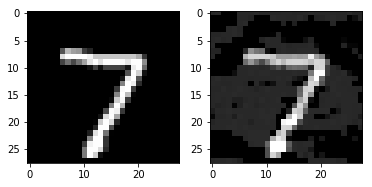

Score: [  7.07576    -7.27487     2.8332064   3.7366335  -5.840443   -6.139279
 -11.717128    7.072272    1.1108091   1.9870304]
output:  0
Total distortion: 3.4000818242717576


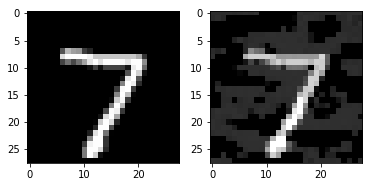

Score: [ -5.3930917   8.137378   -1.6211144   8.039353   -0.7610839   3.06528
 -21.365688    8.136629   -4.937163    3.9976554]
output:  1
Total distortion: 3.723394490840828


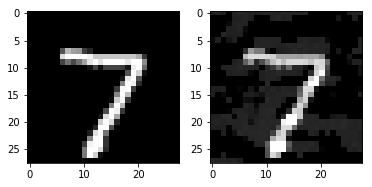

Score: [ -2.3193023   -7.4860053    9.073435     9.02821     -2.025606
  -7.014082   -18.251911     9.0653515    2.7499056   -0.19127476]
output:  2
Total distortion: 2.693865135900898


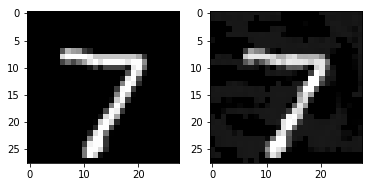

Score: [ -9.98624    -6.9450145  -2.266502   18.66312    -3.5688787  -1.3377343
 -26.586367   18.653688   -3.6949878   5.814276 ]
output:  3
Total distortion: 1.9051113792960226


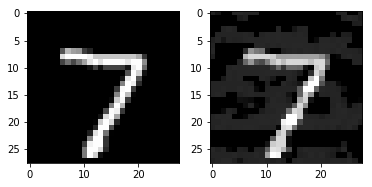

Score: [ -5.8003726  -7.033945   -1.9609953   7.845655    9.23037    -3.7928665
 -18.486576    9.211844   -2.5876524   4.245114 ]
output:  4
Total distortion: 3.0697129613035354


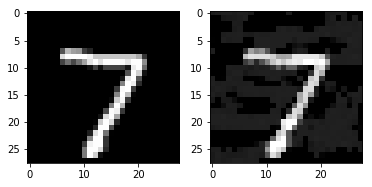

Score: [-11.866778   -7.671943   -5.8534284  11.424491   -3.2745461  12.743689
 -23.358032   12.7404785  -2.3853195   8.12586  ]
output:  5
Total distortion: 2.6286845914400634


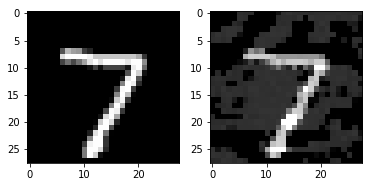

Score: [  2.2951121  -11.7235365   -1.4628305    3.7327232   -7.299319
  -0.547638     3.738879     3.7288382   -0.07912219  -0.8255602 ]
output:  6
Total distortion: 3.973085813450608


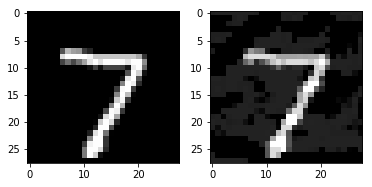

Score: [ -6.2575088   -8.796981     0.38574183   7.3048363   -2.286261
  -1.0920435  -17.648035     8.899909     8.913875     2.371141  ]
output:  8
Total distortion: 2.7728725663902583


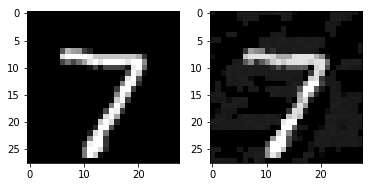

Score: [ -9.810501   -7.8913283  -6.575734   10.266373   -2.1602998   1.1019523
 -25.849234   15.750106   -1.8523458  15.758292 ]
output:  9
Total distortion: 2.111463741777968


In [8]:


for org_img, adv_img in zip(inputs, adv):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(org_img, (28,28)), cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(adv_img, (28,28)), cmap="gray")
#     plt.colorbar()
    plt.show()
    pred_score = model.model.predict(adv_img.reshape( (1,adv_img.shape[0],adv_img.shape[1],adv_img.shape[2] )))
    print("Score:",pred_score[0])
    print('output: ', np.argmax(pred_score[0]) )
    print("Total distortion:", np.sum((adv_img-org_img)**2)**.5)
    
#     break

In [11]:
file_name = 'Li_attack'
np.savez(file_name, inputs, adv)